In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hindienglish-corpora/Hindi_English_Truncated_Corpus.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import string
from string import digits
import re

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

from collections import Counter

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
data = pd.read_csv("/kaggle/input/hindienglish-corpora/Hindi_English_Truncated_Corpus.csv", encoding = 'utf-8')
data.head(10)

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,indic2012,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।
5,tides,The then Governor of Kashmir resisted transfer...,कश्मीर के तत्कालीन गवर्नर ने इस हस्तांतरण का व...
6,indic2012,In this lies the circumstances of people befor...,इसमें तुमसे पूर्व गुज़रे हुए लोगों के हालात हैं।
7,ted,"And who are we to say, even, that they are wrong",और हम होते कौन हैं यह कहने भी वाले कि वे गलत हैं
8,indic2012,“”Global Warming“” refer to warming caused in ...,ग्लोबल वॉर्मिंग से आशय हाल ही के दशकों में हुई...
9,tides,You may want your child to go to a school that...,हो सकता है कि आप चाहते हों कि आप का नऋर्नमेनटे...


In [4]:
data['source'].value_counts()

tides        50000
ted          39881
indic2012    37726
Name: source, dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127607 entries, 0 to 127606
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   source            127607 non-null  object
 1   english_sentence  127605 non-null  object
 2   hindi_sentence    127607 non-null  object
dtypes: object(3)
memory usage: 2.9+ MB


In [6]:
data=data[data['source']=='ted']

data.head(20)

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
7,ted,"And who are we to say, even, that they are wrong",और हम होते कौन हैं यह कहने भी वाले कि वे गलत हैं
13,ted,So there is some sort of justice,तो वहाँ न्याय है
23,ted,This changed slowly,धीरे धीरे ये सब बदला
26,ted,were being produced.,उत्पन्न नहीं कि जाती थी.
30,ted,"And you can see, this LED is going to glow.","और जैसा आप देख रहे है, ये एल.ई.डी. जल उठेगी।"
32,ted,to turn on the lights or to bring him a glass ...,"लाईट जलाने के लिए या उनके लिए पानी लाने के लिए,"
35,ted,Can you imagine saying that?,क्या आप ये कल्पना कर सकते है


In [7]:
data.isnull().sum()

source              0
english_sentence    0
hindi_sentence      0
dtype: int64

In [8]:
data.drop_duplicates(inplace = True)

In [9]:
data.describe()

,source,english_sentence,hindi_sentence
count,38803,38803,38803
unique,1,38629,38743
top,ted,(Applause),धन्यवाद |
freq,38803,39,4


In [10]:
data = data.sample(n = 30000, random_state = 42)
data.shape

(30000, 3)

In [11]:
# Lowercase all characters
data['english_sentence']=data['english_sentence'].apply(lambda x: x.lower())
data['hindi_sentence']=data['hindi_sentence'].apply(lambda x: x.lower())

In [12]:
# Define a function to apply text preprocessing steps
def preprocess_text(text):
    text = text.lower()
    text = re.sub("'", '', text)
    exclude = set(string.punctuation)
    text = ''.join(ch for ch in text if ch not in exclude)
    remove_digits = str.maketrans('', '', digits)
    text = text.translate(remove_digits)
    text = re.sub("[२३०८१५७९४६]", "", text)
    text = text.strip()
    text = re.sub(" +", " ", text)
    return text

# Apply the preprocessing function to the English and Hindi sentences
data['english_sentence'] = data['english_sentence'].apply(preprocess_text)
data['hindi_sentence'] = data['hindi_sentence'].apply(preprocess_text)
data['hindi_sentence'] = data['hindi_sentence'].apply(lambda x: 'START_ ' + x + ' _END')

In [13]:
all_eng_words = set(word for eng in data['english_sentence'] for word in eng.split())
all_hindi_words = set(word for hin in data['hindi_sentence'] for word in hin.split())

print(len(all_eng_words))
all_eng_words

15348


{'patronage',
 '“egypt',
 'sparking',
 'satchels',
 'specimen',
 'anjali',
 'occupy',
 'is“',
 'cakes',
 'wembley',
 'friendship',
 '“same',
 'pride',
 'debt',
 'yearbook',
 'remotely',
 'volunteering',
 '“hamlet',
 'diaspora',
 'dwellers',
 'loop',
 'colonization',
 'angry',
 'transgression',
 'wings',
 'swami',
 'cup',
 'accidental',
 'created',
 'democratization',
 'gangstabuckscom',
 'compassionate”',
 'stations',
 'related',
 'opossums',
 'voyager',
 'objects',
 'tank',
 'afternoon',
 'green',
 'lockers',
 'irony',
 'politicians',
 'disappear',
 'treble',
 'micromanaging',
 'eroded',
 'needlepointing',
 'seizures',
 'sunflowers',
 'principled',
 'fitted',
 'hitting',
 'periods',
 'ships',
 'civil',
 'desktops',
 'ribcage',
 'gloves',
 'tissue',
 'reporting',
 'attracts',
 'raghupati',
 'advertised',
 'toll',
 'mixed',
 'applications',
 'hostile',
 'plenty',
 'overgrazing',
 'bandages”',
 'fielder',
 'metabolizing',
 'herbavate',
 'deconstructing',
 'surprises',
 'interaction',
 's

In [14]:
print(len(all_hindi_words))
all_hindi_words

19406


{'माइक',
 'रोक',
 'दार्शनिक',
 'बिकी',
 'सुननाने',
 'दोस्त',
 'उन्नत',
 'वाल्व',
 'ऊँगली',
 'घूमें',
 'कोलकाता',
 'बैरा',
 'लडतेभिडते',
 'उपशीर्षक',
 'प्राथमिकताऐ',
 'जेरेमी',
 'हिलता',
 'आदतें',
 '“ऐस',
 'जिनकी',
 'हुआ',
 'पढ़ेलिखे',
 'छोकरों',
 'मानवविज्ञानी',
 'क्रिकेटर',
 'खिताबों',
 'सायनाइड',
 'भावनाओं',
 'मिलाकर',
 'हाजी',
 'गर्मीयों',
 'लिमिटिड',
 'कहूँ',
 'फुसफुसाते',
 'सहमती',
 'अर्थहीन',
 'करें',
 'अल्लामा',
 'उपमा',
 'gangstabuckscom',
 'विश्वभर',
 'मालवाहक',
 'संशोधन',
 'प्रांसगिक',
 'एपी',
 'रूढ़िवादी',
 'सैनिटरी',
 'सुरक्षित',
 'afternoon',
 'हिप्पोक्रेट्स',
 'जिंदाबाद”“तुलसी',
 'फ्रब्बरfrubber',
 'मिनेट',
 'बॉल',
 'झुकाना',
 'प्रोमिस्क्युस',
 'सोबुले',
 'सहायता',
 'सागर',
 'टैब',
 'लॉबी',
 'मुझमैं',
 'जीतती',
 'बर्तन',
 'सीन',
 'लिफ्ट',
 'पढ़ाकू',
 'खींची',
 'प्रोटेओलाइसिस',
 'मालूम',
 'शास्त्र',
 'खिले',
 'ग्रेंटॊलॊजी',
 'नन्ही',
 'लाइफ़स्प्रिंग',
 'सीएalain',
 'नही…',
 'अफ़्रीकावासियों',
 'उपदेशों',
 'बकवास',
 'काटना',
 'मध्यपूर्व',
 'परवरिश',
 'ब्रियन',
 'दस्तावेज़ों

In [15]:
data['len_eng_sentence'] = data['english_sentence'].apply(lambda x: len(x.split(" ")))

data['len_hindi_sentence'] = data['hindi_sentence'].apply(lambda x: len(x.split(" ")))

In [16]:
data.head()

,source,english_sentence,hindi_sentence,len_eng_sentence,len_hindi_sentence
82040,ted,we still dont know who her parents are who she is,START_ हम अभी तक नहीं जानते हैं कि उसके मातापि...,11,16
85038,ted,no keyboard,START_ कोई कुंजीपटल नहीं _END,2,5
58018,ted,but as far as being a performer,START_ लेकिन एक कलाकार होने के साथ _END,7,8
74470,ted,and this particular balloon,START_ और यह खास गुब्बारा _END,4,6
122330,ted,and its not as hard as you think integrate cli...,START_ और जितना आपको लगता है यह उतना कठिन नहीं...,16,20


In [17]:
data["eng_char_count"] = data["english_sentence"].str.len()
data["hindi_char_count"] = data["hindi_sentence"].str.len()
data["hindi_tok_count"] = data["hindi_sentence"].str.split(" ").str.len()
data["eng_tok_count"] = data["english_sentence"].str.split(" ").str.len()

In [18]:
total_english_sentences = " "
for eng_sent in data['english_sentence'].tolist():
  total_english_sentences += eng_sent + " "

Counter(total_english_sentences.split(" ")).most_common(20)

[('the', 10899),
 ('and', 7583),
 ('to', 6544),
 ('of', 5913),
 ('a', 5494),
 ('that', 4241),
 ('in', 4141),
 ('i', 3607),
 ('is', 3441),
 ('you', 3421),
 ('we', 2841),
 ('it', 2718),
 ('this', 2499),
 ('so', 1932),
 ('was', 1596),
 ('for', 1531),
 ('are', 1522),
 ('have', 1518),
 ('they', 1480),
 ('what', 1329)]

In [19]:
total_hindi_sentences = " "
for hindi_sent in data['hindi_sentence'].tolist():
  total_hindi_sentences += hindi_sent + " "

Counter(total_hindi_sentences.split(" ")).most_common(20)

[('START_', 30000),
 ('_END', 30000),
 ('है', 9047),
 ('और', 7405),
 ('के', 7204),
 ('में', 6439),
 ('हैं', 4767),
 ('से', 4291),
 ('की', 4084),
 ('एक', 3941),
 ('कि', 3743),
 ('को', 3297),
 ('यह', 2677),
 ('का', 2625),
 ('नहीं', 2550),
 ('हम', 2127),
 ('मैं', 2102),
 ('आप', 2074),
 ('तो', 2051),
 ('जो', 1985)]

In [20]:
!pip install fasteda

  Preparing metadata (setup.py) ... done
  Created wheel for fasteda: filename=fasteda-1.0.1-py3-none-any.whl size=4740 sha256=3ac0954a28f53f8515f902a68c5c4ede2eb13603b1b6f5ca3bba3f63270944a7
  Stored in directory: /root/.cache/pip/wheels/ed/08/72/0d0ec0d3927d227b38ce9542ec3fa6b975c2e17ad0d046dcee
Successfully built fasteda


DataFrame Head:


,source,eng_char_count,hindi_char_count,hindi_tok_count,eng_tok_count
82040,ted,49,71,16,11
85038,ted,11,29,5,2
58018,ted,31,39,8,7


DataFrame Tail:


,source,eng_char_count,hindi_char_count,hindi_tok_count,eng_tok_count
99741,ted,38,41,10,6
75740,ted,32,55,11,8
10643,ted,61,57,13,13


----------------------------------------------------------------------------------------------------
Missing values:


,0


----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(30000, 5)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 82040 to 10643
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   source            30000 non-null  object
 1   eng_char_count    30000 non-null  int64 
 2   hindi_char_count  30000 non-null  int64 
 3   hindi_tok_count   30000 non-null  int64 
 4   eng_tok_count     30000 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 1.4+ MB
----------------------------------------------------------------------------------------------------
Describe DataFrame:



,count,mean,median,std,min,25%,50%,75%,max,skewness,kurtosis
eng_char_count,30000,39.086,38,15.059,0,28,38,49,104,0.354416,-0.212670
hindi_char_count,30000,50.804,49,16.359,12,39,49,61,142,0.629750,0.493559
hindi_tok_count,30000,10.449,10,3.558,3,8,10,13,30,0.659646,0.559485
eng_tok_count,30000,7.485,7,2.989,1,5,7,9,20,0.472779,0.007210


----------------------------------------------------------------------------------------------------
DataFrame Correlation:



/opt/conda/lib/python3.10/site-packages/fasteda/__init__.py:124: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True, cmap = "Spectral", linewidths = 2, linecolor = "#000000", fmt='.3f')


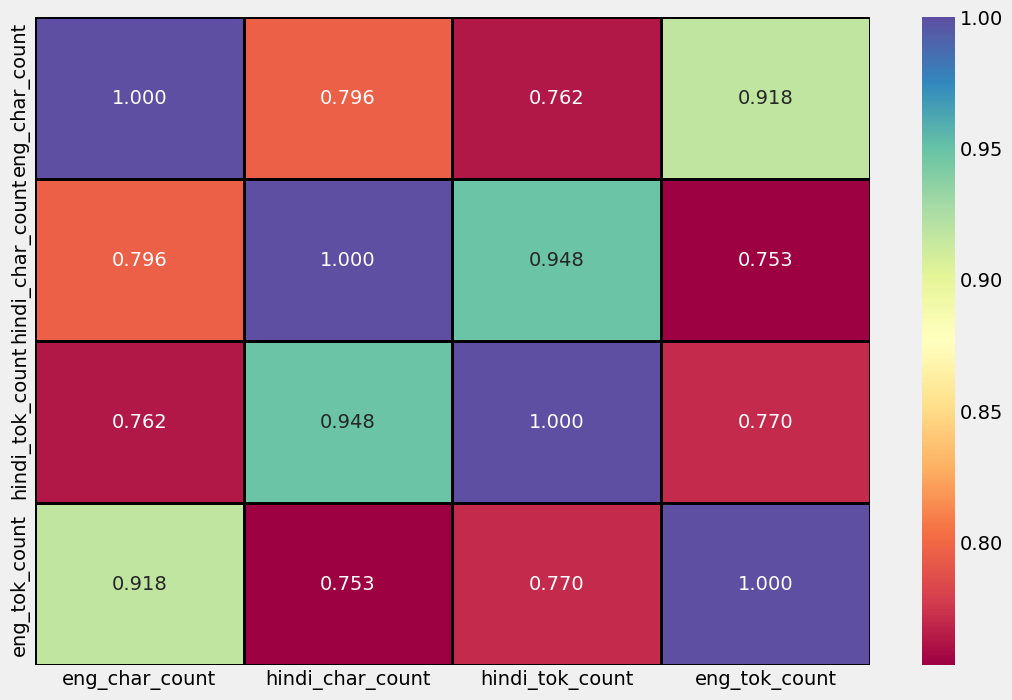

----------------------------------------------------------------------------------------------------
DataFrame Pairplot:



/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


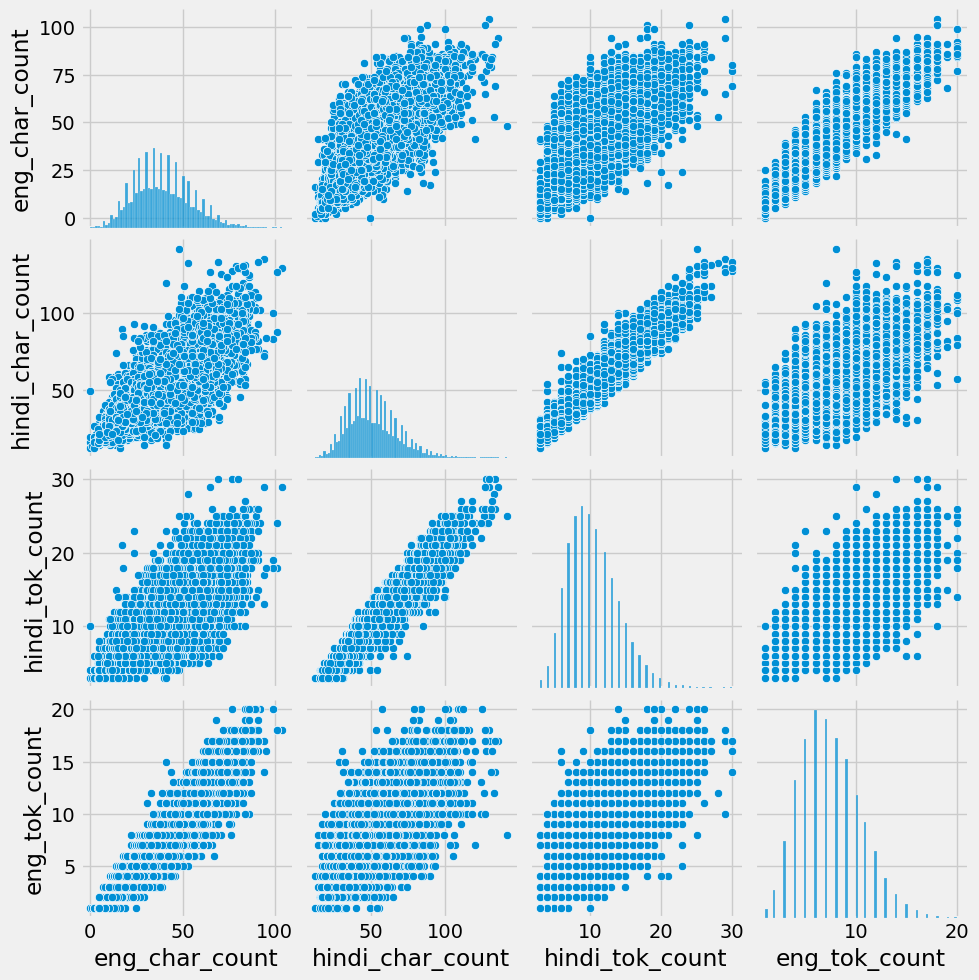

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



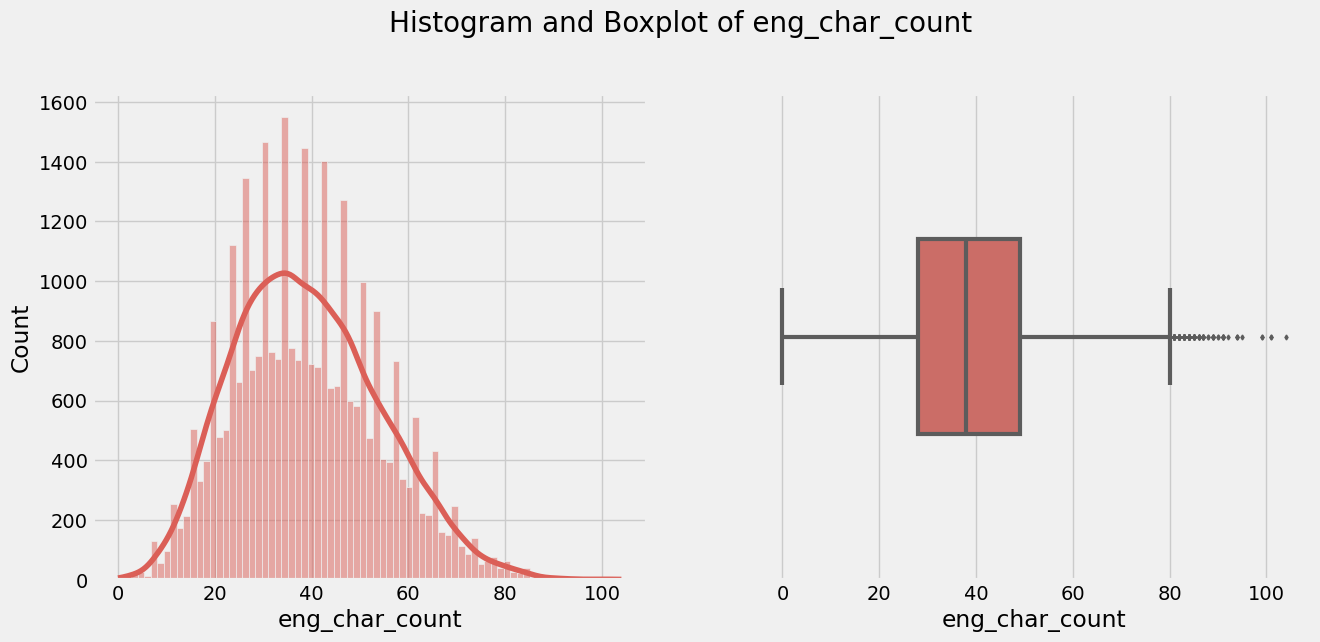

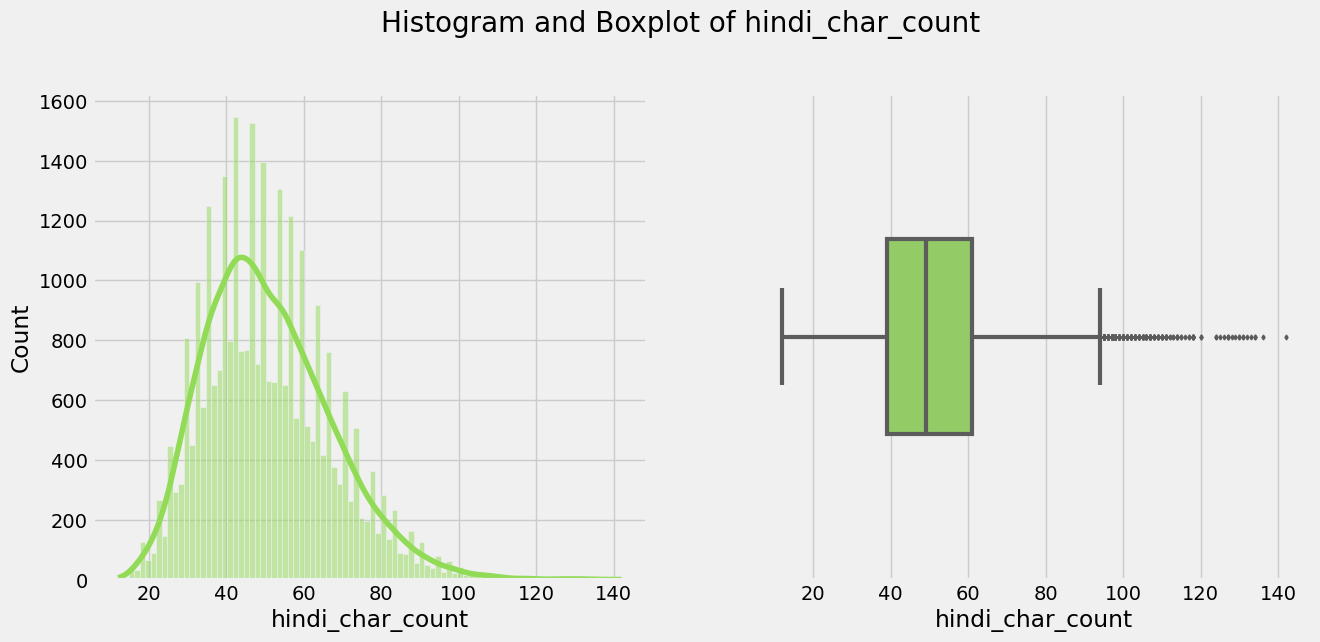

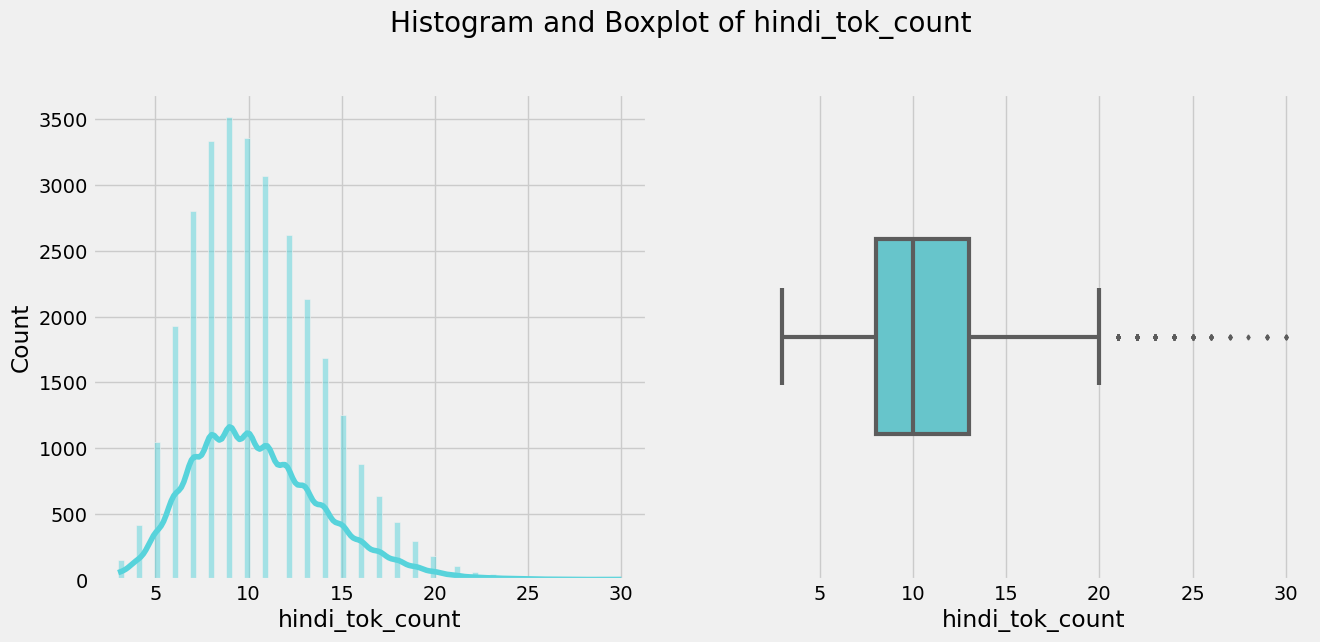

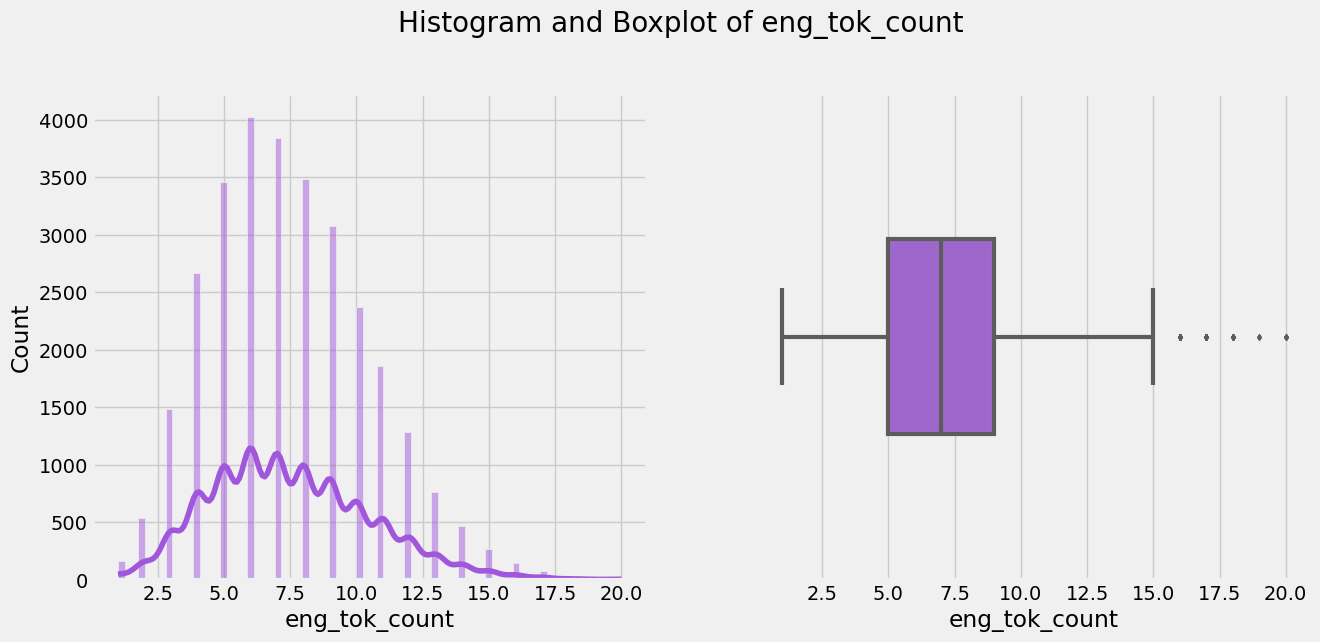

----------------------------------------------------------------------------------------------------
Countplot(s):



<Figure size 1200x800 with 0 Axes>

In [21]:
from fasteda import fast_eda

fast_eda(data[["source", "eng_char_count", "hindi_char_count", "hindi_tok_count",
               "eng_tok_count",]])

In [22]:
data[data['len_eng_sentence']>30].shape

(0, 9)

In [23]:
data = data[data['len_eng_sentence']<=20]
data = data[data['len_hindi_sentence']<=20]

data

,source,english_sentence,hindi_sentence,len_eng_sentence,len_hindi_sentence,eng_char_count,hindi_char_count,hindi_tok_count,eng_tok_count
82040,ted,we still dont know who her parents are who she is,START_ हम अभी तक नहीं जानते हैं कि उसके मातापि...,11,16,49,71,16,11
85038,ted,no keyboard,START_ कोई कुंजीपटल नहीं _END,2,5,11,29,5,2
58018,ted,but as far as being a performer,START_ लेकिन एक कलाकार होने के साथ _END,7,8,31,39,8,7
74470,ted,and this particular balloon,START_ और यह खास गुब्बारा _END,4,6,27,30,6,4
122330,ted,and its not as hard as you think integrate cli...,START_ और जितना आपको लगता है यह उतना कठिन नहीं...,16,20,89,104,20,16
...,...,...,...,...,...,...,...,...,...
104973,ted,and i have this email from one of our students,START_ और मुझे एक छात्र का ईमेल मिला _END,10,9,46,41,9,10
86758,ted,can actually afford to invest into their attacks,START_ वास्तव में उनके हमलों में निवेश के लिए ...,8,14,48,67,14,8
99741,ted,and were discovering with our research,START_ और हम अपने शोध से खोज रहे हैं _END,6,10,38,41,10,6
75740,ted,we had a lot that got us excited,START_ हमारे पास बहोत था हमें उत्साहित करने के...,8,11,32,55,11,8


In [24]:
print("maximum length of Hindi Sentence ",max(data['len_hindi_sentence']))
print("maximum length of English Sentence ",max(data['len_eng_sentence']))

maximum length of Hindi Sentence  20
maximum length of English Sentence  20


In [25]:
max_length_src=max(data['len_hindi_sentence'])
max_length_tar=max(data['len_eng_sentence'])

In [26]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_hindi_words))
num_encoder_tokens, num_decoder_tokens = len(input_words), len(target_words) + 1

input_token_index = {word: i + 1 for i, word in enumerate(input_words)}
target_token_index = {word: i + 1 for i, word in enumerate(target_words)}
reverse_input_char_index = {i: word for word, i in input_token_index.items()}
reverse_target_char_index = {i: word for word, i in target_token_index.items()}

num_encoder_tokens, num_decoder_tokens

(15348, 19407)

In [27]:
data = shuffle(data)
data.head(10)

,source,english_sentence,hindi_sentence,len_eng_sentence,len_hindi_sentence,eng_char_count,hindi_char_count,hindi_tok_count,eng_tok_count
125011,ted,love and passionate about classical music,START_ जो शास्त्रीय संगीत के प्रति प्रेम और लग...,6,12,41,62,12,6
118552,ted,is a particularly,START_ विशेश तौर पे _END,3,5,17,24,5,3
25093,ted,mock drum roll,START_ बनावटी ढोल की आवाज़ _END,3,6,14,31,6,3
87349,ted,i started putting myself in a better mood,START_ मुझे यह सब अच्छा लगने लगा _END,8,8,41,37,8,8
16764,ted,is china,START_ चीन है। _END,2,4,8,19,4,2
3512,ted,its about conversation and faith,START_ यहाँ बातचीत और विश्वास पर ज्यादा ज़ोर ह...,5,11,32,54,11,5
37413,ted,of microorganisms inside,START_ को विकसित कर सकें _END,3,6,24,29,6,3
108194,ted,and theres no wires,START_ और वहां कोई वायर नहीं है _END,4,8,19,36,8,4
85914,ted,i cant emphasize enough,START_ मै इस पर और पर्याप्त ज़ोर नही दे सकती _END,4,11,23,49,11,4
8555,ted,it was built by barefoot architects,START_ इसे बेयरफ़ुट आर्किटेक्टों ने बनाया था _END,6,8,35,49,8,6


In [28]:
X, y = data['english_sentence'], data['hindi_sentence']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = 42)

X_train.shape, X_test.shape

((23794,), (5949,))

In [29]:
# Defining a batch function:
def generate_batch(X=X_train, y=y_train, batch_size=128):
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),
                                          dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),
                                          dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar,
                                            num_decoder_tokens),
                                            dtype='float32')

            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size],
                                                            y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word]

                for t, word in enumerate(target_text.split()):
                    if t < len(target_text.split()) - 1:
                        decoder_input_data[i, t] = target_token_index[word]
                    if t > 0:
                        decoder_target_data[i, t - 1,
                                            target_token_index[word]] = 1.

            yield [encoder_input_data, decoder_input_data], decoder_target_data

In [30]:
latent_dim = 300

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [31]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 300)    4604400     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 300)    5822100     ['input_2[0][0]']                
                                                                                              

In [33]:
train_samples, val_samples = len(X_train), len(X_test)
batch_size, epochs = 128, 100

model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

/tmp/ipykernel_28/1399644401.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),


Epoch 1/100
185/185 [==============================] - 109s 518ms/step - loss: 6.8568 - val_loss: 6.3369
Epoch 2/100
185/185 [==============================] - 80s 431ms/step - loss: 6.3029 - val_loss: 6.3034
Epoch 3/100
185/185 [==============================] - 84s 458ms/step - loss: 6.2612 - val_loss: 6.2799
Epoch 4/100
185/185 [==============================] - 85s 458ms/step - loss: 6.1974 - val_loss: 6.1936
Epoch 5/100
185/185 [==============================] - 85s 460ms/step - loss: 6.0916 - val_loss: 6.0959
Epoch 6/100
185/185 [==============================] - 84s 457ms/step - loss: 5.9887 - val_loss: 6.0027
Epoch 7/100
185/185 [==============================] - 84s 458ms/step - loss: 5.8912 - val_loss: 5.9328
Epoch 8/100
185/185 [==============================] - 84s 457ms/step - loss: 5.8112 - val_loss: 5.8640
Epoch 9/100
185/185 [==============================] - 84s 457ms/step - loss: 5.7350 - val_loss: 5.8140
Epoch 10/100
185/185 [==============================] - 84s 458

In [34]:
model.save_weights('nmt_weights.h5')

In [35]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model([decoder_inputs] + decoder_states_inputs,[decoder_outputs2] + decoder_states2)

In [36]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_token_index['START_']
    decoded_sentence = ''
    
    while True:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' ' + sampled_char
        
        if (sampled_char == '_END' or len(decoded_sentence) > 50):
            break
        
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
    
    return decoded_sentence

In [37]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [40]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

1/1 [==============================] - 0s 21ms/step
Input English sentence: so i can pretend i speak chinese fluently
Actual Hindi Translation:  ताकि मैं बेधड़क चीनी बोलने का नाटक कर सकता हूँ। 
Predicted Hindi Translation:  तो मैं आपको पहला प्रयोग कर सकता हूँ 


In [41]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

1/1 [==============================] - 0s 21ms/step
Input English sentence: to keep pushing forward
Actual Hindi Translation:  हमें हृदय की योजना का विकास करने के लिए 
Predicted Hindi Translation:  हमें वास्तविक रूप से ही विकास कर रहे हैं 


## Acknowledgements:

1. https://www.kaggle.com/code/vshantam/machine-translation-eng-hin
2. https://www.kaggle.com/code/ritesh2000/english-to-hindi-neural-machine-translation/notebook
3. https://towardsdatascience.com/english-to-hindi-neural-machine-translation-7cb3a426491f